In [1]:
import numpy as np
import scipy.stats as ss
import emcee
import time
import scipy
import h5py
from scipy.stats import gaussian_kde, wishart, poisson, norm, multivariate_normal, dirichlet
from scipy.special import logsumexp
from scipy.interpolate import interp1d
import dynesty
from dynesty.utils import resample_equal

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn
import corner
import matplotlib.lines as mlines

In [2]:
from functions import * 
from cov15d import *

In [3]:
params = {'font.family': 'DejaVu Serif',
          'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'xtick.direction':'in',
          'ytick.direction':'in',
          'ytick.labelsize':'large','font.size':19}
plt.rcParams.update(params)
inches_to_cm = 2.54
figsize = (40/inches_to_cm, 13/inches_to_cm)
dpi = 180

### Define Model

In [4]:
ndim = 15
mu1 = 4 * np.sqrt(np.diag(cov))
mu2 = -4 * np.sqrt(np.diag(cov))

f = np.array([0.5, 0.5])

def log_prob(x):
    lp1 = ss.multivariate_normal.logpdf(x, mean=mu1, cov=cov)
    lp2 = ss.multivariate_normal.logpdf(x, mean=mu2, cov=cov)
    
    lpdf = np.logaddexp(lp1 + np.log(f[0]), lp2 + np.log(f[1]))
    return lpdf

true = []
mu = [mu1, mu2]
covar = [cov, cov]
for ii in range(2):
    true.append(ss.multivariate_normal.rvs(size = int(1000000 * f[ii]), mean=mu[ii], cov=covar[ii]))
true = np.vstack(true)

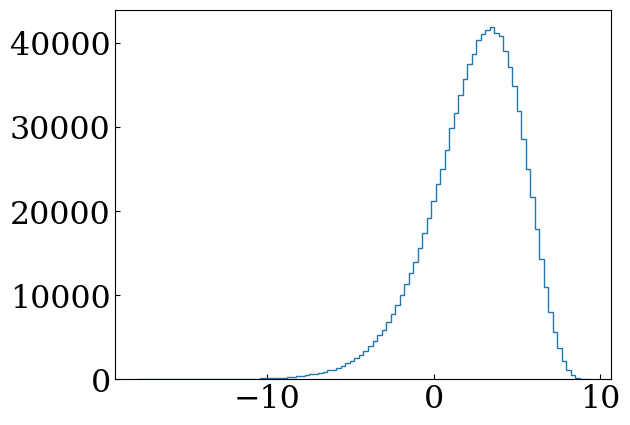

In [5]:
xx = plt.hist(log_prob(true), histtype='step', bins=100)

### Sample Using Varaha

In [6]:
# User provided
maxx = 5
nsel = 2000# number of largest log-likelihood samples selected to estimate lkl_thr for the next cycle.
perc_acc = 1/np.sqrt(nsel)
xrange = np.vstack([[-maxx, maxx]  for ii in range(ndim)]) #Start with a large rectangular bix same as emcee.
xbox = np.array([[0, 1]] * ndim)#Start with a box.
#Sampler
nmc = 40000# Number of samples at which likelihood is calculated in each cycle
allx, allloglkl = np.transpose([[]] * ndim), []
cycle = 1
dx, binunique, nbins, ninbin = {}, {}, {}, {}
dx[cycle] = np.diff(xbox, axis = 1).flatten()
binunique[cycle] = np.array([ndim * [0]]) #There is only one unique bin in the beginning
# The number of samples in each unique bin. There is only one so all samples go there
ninbin[cycle] = nmc
nbins[cycle] = np.ones(ndim)
allx_log_injd = []
neff_varaha = 0
log_V = frac = injneff = Z_jump = 0
log_delta_V = -np.inf
lkl_thr = -np.inf
pinside = 1
t0 = time.time()

while pinside > 0.01:
    
    log_LivV = np.log(binunique[cycle].shape[0]) - np.log(nbins[cycle]).sum()
    x = sample_from_bins(xbox, dx[cycle], binunique[cycle], ninbin[cycle])
    xprior = xrange.T[0] + x * np.diff(xrange).flatten()#map back to original prior
    loglkl = log_prob(xprior)
    allx_log_injd, log_injd_x, InsLiveVol = \
            update_injection_density(allx, x, allx_log_injd, xbox, dx, binunique, ninbin, cycle)
    
    allx = np.append(allx, x, axis = 0)
    allloglkl = np.append(allloglkl, loglkl)
    allx_log_injd = np.append(allx_log_injd, log_injd_x)
    
    lw = allloglkl - allx_log_injd
    Z = logsumexp(lw)
    lw -= lw.max()
    w = np.exp(lw)
    neff_varaha = w.sum() ** 2 / (w**2).sum()
    
    print(cycle, rnd(neff_varaha), rnd(np.max(allloglkl), 1), np.exp(log_V), np.exp(log_delta_V-log_V), frac, injneff, pinside, lkl_thr)
    cycle += 1
    
    idxsel = np.where(allloglkl >= lkl_thr)
    frac, next_lkl_thr, injneff, pin = get_likelihood_threshold(allloglkl[idxsel], allx_log_injd[idxsel], nsel)
    if frac < 0.9 and np.exp(log_delta_V - log_V) <= perc_acc: 
        lkl_thr = next_lkl_thr
        log_V += np.log(frac)
        log_delta_V = log_V - 0.5 * np.log(injneff)
        lw = allloglkl - allx_log_injd
        Z_jump = logsumexp(lw)
        pinside *= pin
    else:
        idxsel = np.where(allloglkl[InsLiveVol] >= lkl_thr)
        log_injw = -allx_log_injd[InsLiveVol]
        injw = np.exp(log_injw - log_injw.max())
        frac = injw[idxsel].sum()/injw.sum()
        injneff = injw[idxsel].sum() ** 2 / (injw[idxsel] ** 2).sum()
        log_V_from_LivV = np.log(frac) + log_LivV
        log_delta_V_from_LivV = log_V_from_LivV - 0.5*np.log(injneff)
        
        #Calculate error weighted mean and the associated error -- improve accuracy on log_V
        log_V = np.logaddexp(log_V - 2*log_delta_V, log_V_from_LivV - 2*log_delta_V_from_LivV)
        log_delta_V = -0.5 * np.logaddexp(-2 * log_delta_V, -2 * log_delta_V_from_LivV)
        log_V += 2 * log_delta_V

    idxsel = np.where(allloglkl >= lkl_thr)
    selx = sample_uniformly_on_cdf(allx[idxsel], allloglkl[idxsel], allx_log_injd[idxsel])
        
    mbin = np.exp(-log_delta_V/ndim)
    nbin = np.maximum(1, norm.rvs(loc = mbin, scale = np.sqrt(mbin), size = (100000, ndim))).astype(int)
    nbins[cycle] = nbin[np.argmin(np.abs(nbin.prod(axis=1) - 1/np.exp(log_delta_V)))]
        
    dx[cycle] = np.diff(xbox, axis = 1).flatten() / nbins[cycle]
    binidx = ((selx - xbox.T[0]) / dx[cycle]).astype(int) #bin indexs of the samples
    
    binunique[cycle] = np.unique(binidx, axis = 0)
    ninbin[cycle] = int(nmc // binunique[cycle].shape[0] + 0.5)
    
    if cycle > 500:
        break
allx = xrange.T[0] + allx * np.diff(xrange).flatten()#map back to original prior
print ('Time taken Varaha:', np.round(time.time() - t0, 1))

1 1.0 -244.2 1.0 0.0 0 0 1 -inf
2 1.0 -244.2 0.05 0.02236067977499789 0.05 2000.0 1.0 -985.0180881015569
3 1.0 -244.2 0.022711787417669778 0.02236067977499791 0.4542357483533954 2000.0 1.0 -855.4269704149559
4 1.0 -244.2 0.020394084740646624 0.013777776876598029 0.0385054570218149 3297.967202971258 1.0 -855.4269704149559
5 1.0 -244.2 0.00803223552271872 0.022358702726766776 0.39385123798715976 2000.3537120493334 1.0 -729.2196078994882
6 1.0 -244.2 0.0057768617090217834 0.022359675535875985 0.7192097010455256 2000.1796558580593 1.0 -689.3126988561578
7 1.0 -244.2 0.004523033495807481 0.02235861953606696 0.7829568585212646 2000.3685976852305 1.0000000000000002 -662.1801182245122
8 1.0 -244.2 0.0035196582561203543 0.02235652351212069 0.7781632082501312 2000.7437022517013 1.0000000000000002 -636.7557565906717
9 1.0 -216.3 0.0027832140236934183 0.022360462108927125 0.7907625744214432 2000.038937859 1.0 -614.898111528795
10 1.0 -216.3 0.0023227110340312746 0.02235897832307401 0.8345427316254

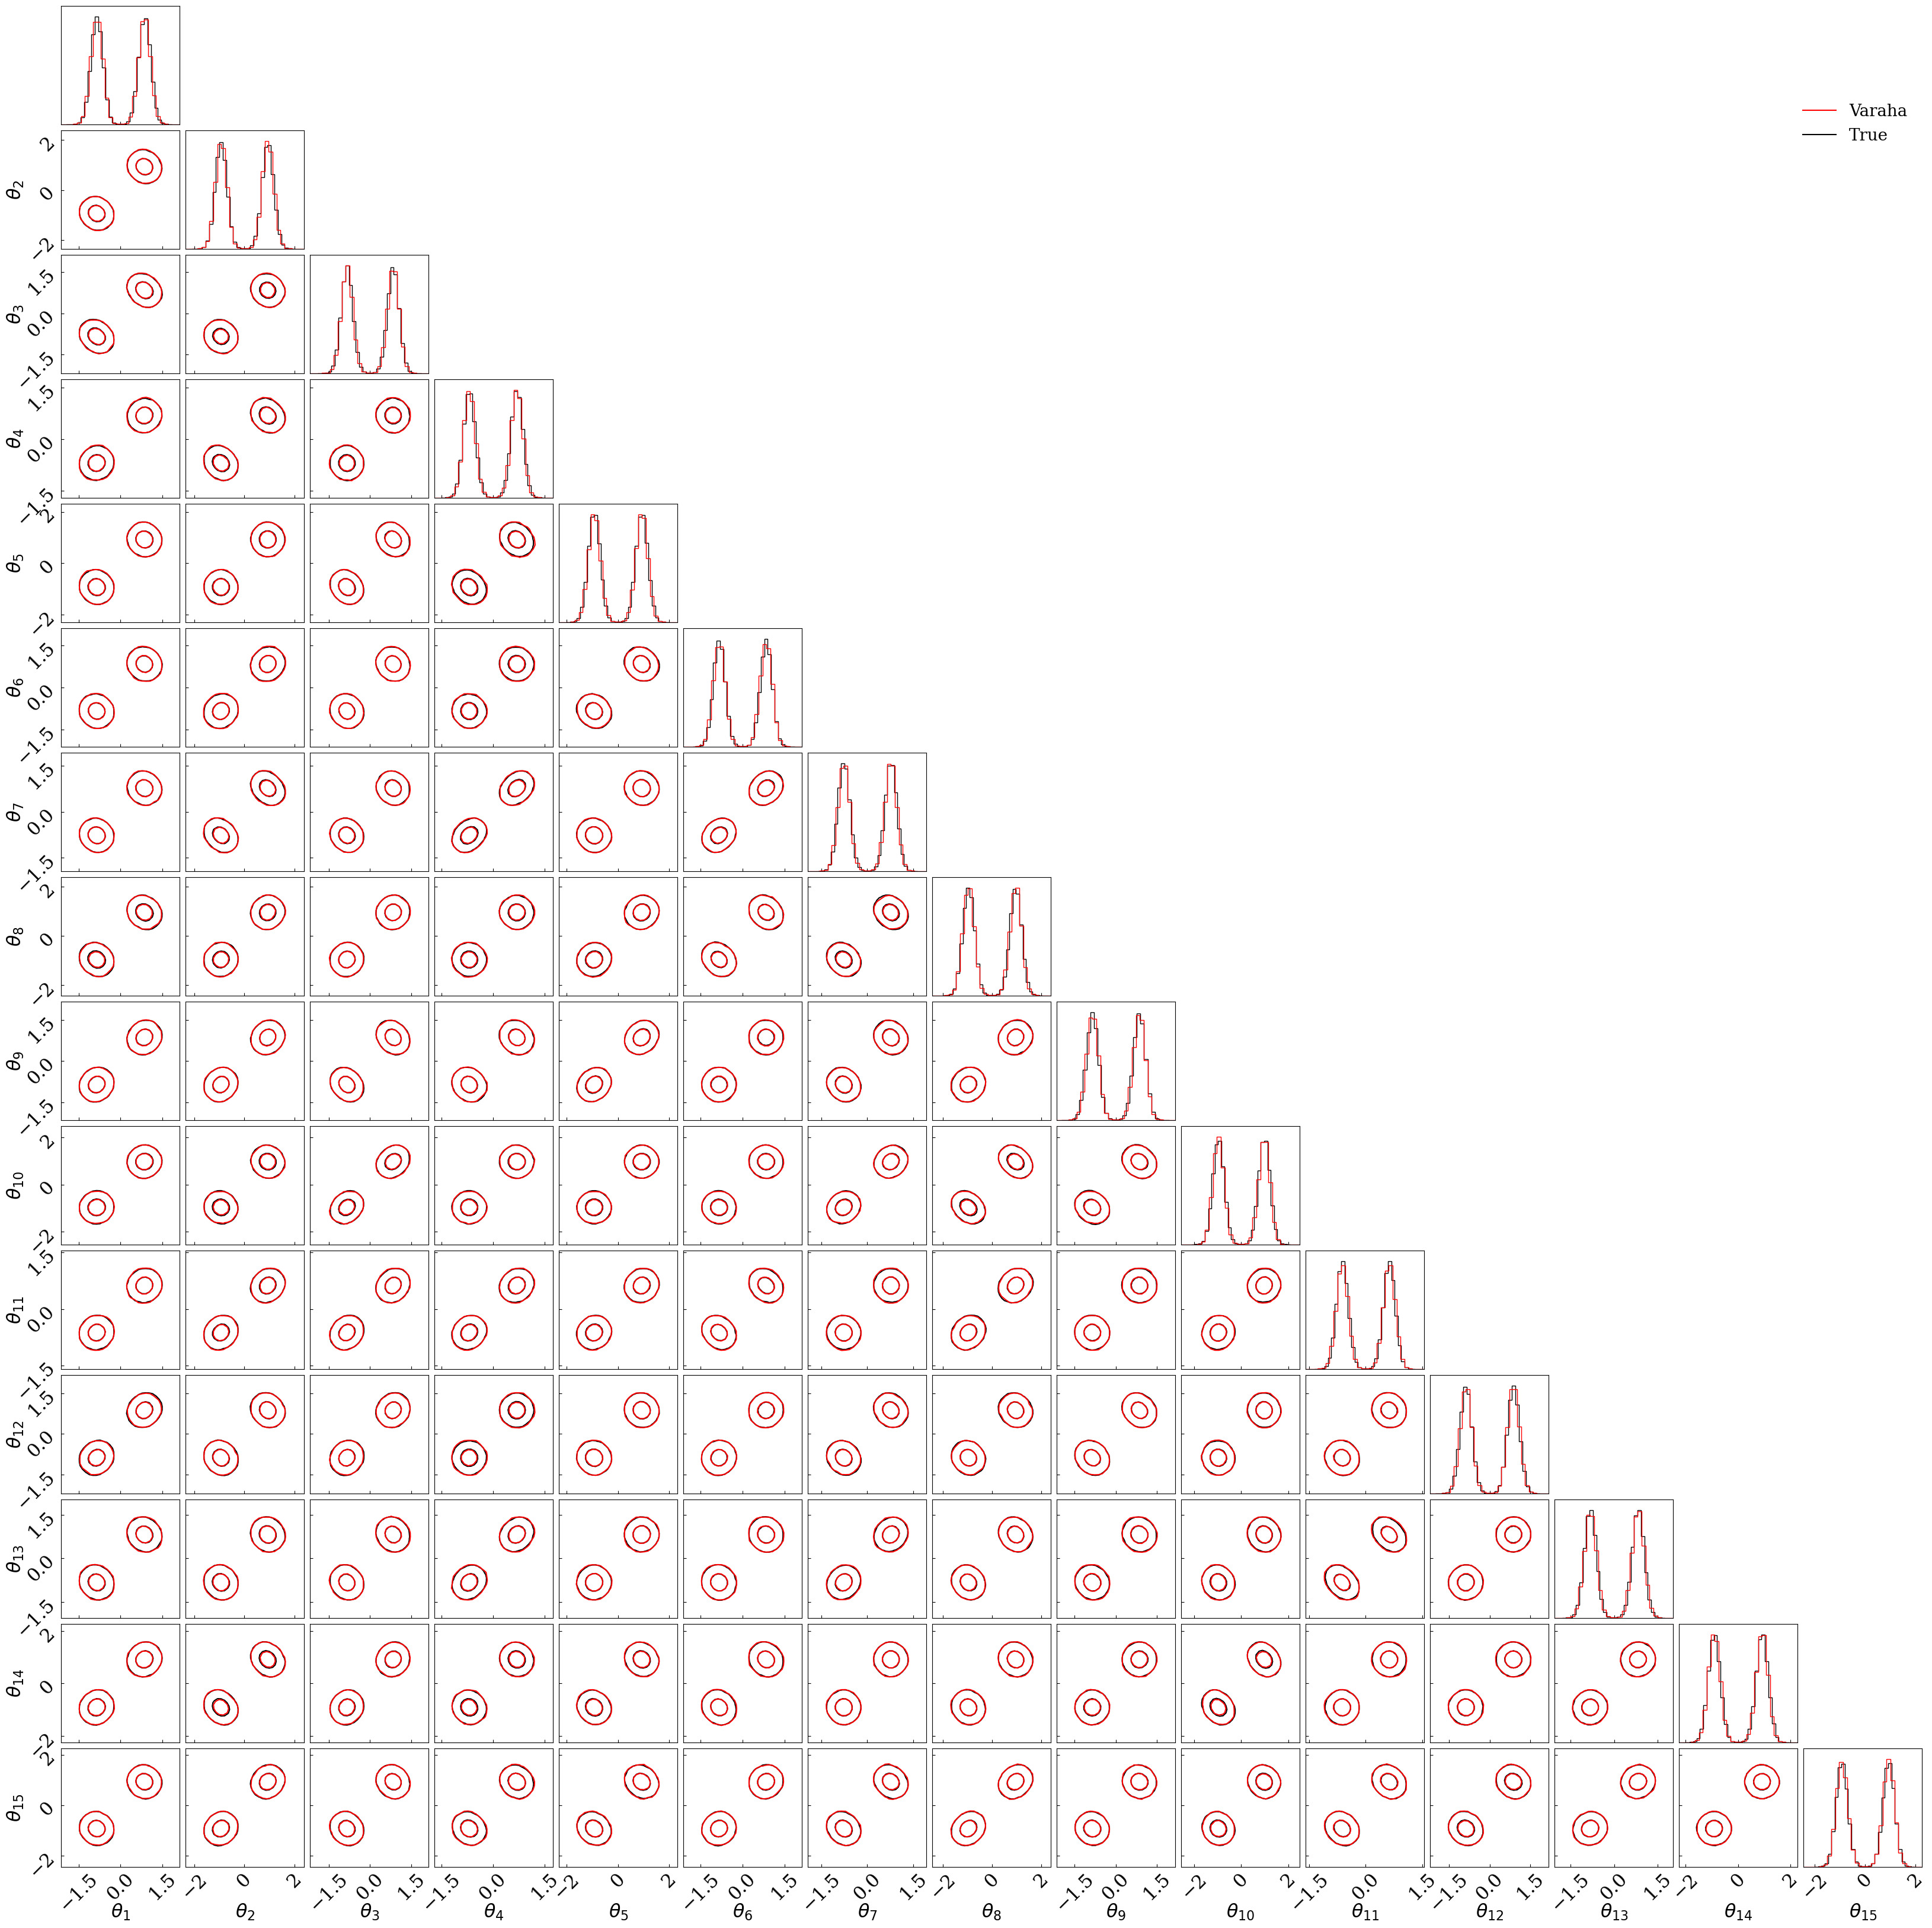

In [7]:
idx = np.where(w > 0.0000001)

l=[]
for ii in range(ndim):
    l.append(r'$\theta_{' + str(ii+1) + '}$')
hh = dict(density=True, color = 'black')
figure = corner.corner(true, bins = 30, levels=(1 - np.exp(-1.), 1 - np.exp(-4.0)), plot_density=False, 
                       plot_datapoints=False, color = 'black',labels=l, hist_kwargs=hh, max_n_ticks=5)
hh = dict(density=True, color = 'red')
corner.corner(allx[idx], fig=figure, color='red', bins = 30, levels=(1 - np.exp(-1.), 1 - np.exp(-4.0)), 
              plot_density=False, plot_datapoints=False, weights=w[idx], hist_kwargs=hh, max_n_ticks=3)
plt.legend(handles=[mlines.Line2D([], [], color='red', label='Varaha'), 
                    mlines.Line2D([], [], color='black', label='True')], fontsize=20, frameon=False, 
           bbox_to_anchor=(1, ndim), loc="upper right")
plt.savefig('files/bimodal_gaussian.jpg', dpi = 200., bbox_inches  = 'tight')

In [8]:
#Marginal likelihood
log_injw = -allx_log_injd 
Z = logsumexp(allloglkl + log_injw)
Zarr = []
idx = np.arange(len(allloglkl))
for ii in range(100):
    idx = np.random.choice(np.arange(len(allloglkl)), replace = False, size = len(allloglkl) // 400)
    Zarr = np.append(Zarr, logsumexp(allloglkl[idx] + log_injw[idx]) + np.log(400))
print (Z, '+/-', np.std(Zarr)/20)

-34.77402232449038 +/- 0.003353141234555835


In [9]:
#run dynesty
# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -10. and 10. in each variable."""
    return maxx * (2. * u - 1.)

# multivariate slice sampling ('slice') 
t0 = time.time()

sampler = dynesty.NestedSampler(log_prob, prior_transform, ndim, nlive = 2000, sample= 'rwalk', walks= 100)
sampler.run_nested(dlogz=0.1)
res = sampler.results

print ('Time taken Dynesty:', np.round(time.time() - t0, 1))

91290it [1:40:10, 15.19it/s, +2000 | bound: 281 | nc: 1 | ncall: 8480142 | eff(%):  1.100 | loglstar:   -inf <  8.820 <    inf | logz: -34.539 +/-  0.139 | dlogz:  0.000 >  0.100]


Time taken Dynesty: 6012.0


In [10]:
dweights = np.exp(res['logwt'] - res['logz'][-1])
dpostsamples = resample_equal(res.samples, dweights)
ns_idx = np.where(np.cumsum(dweights)/dweights.max() > 0.0000001)

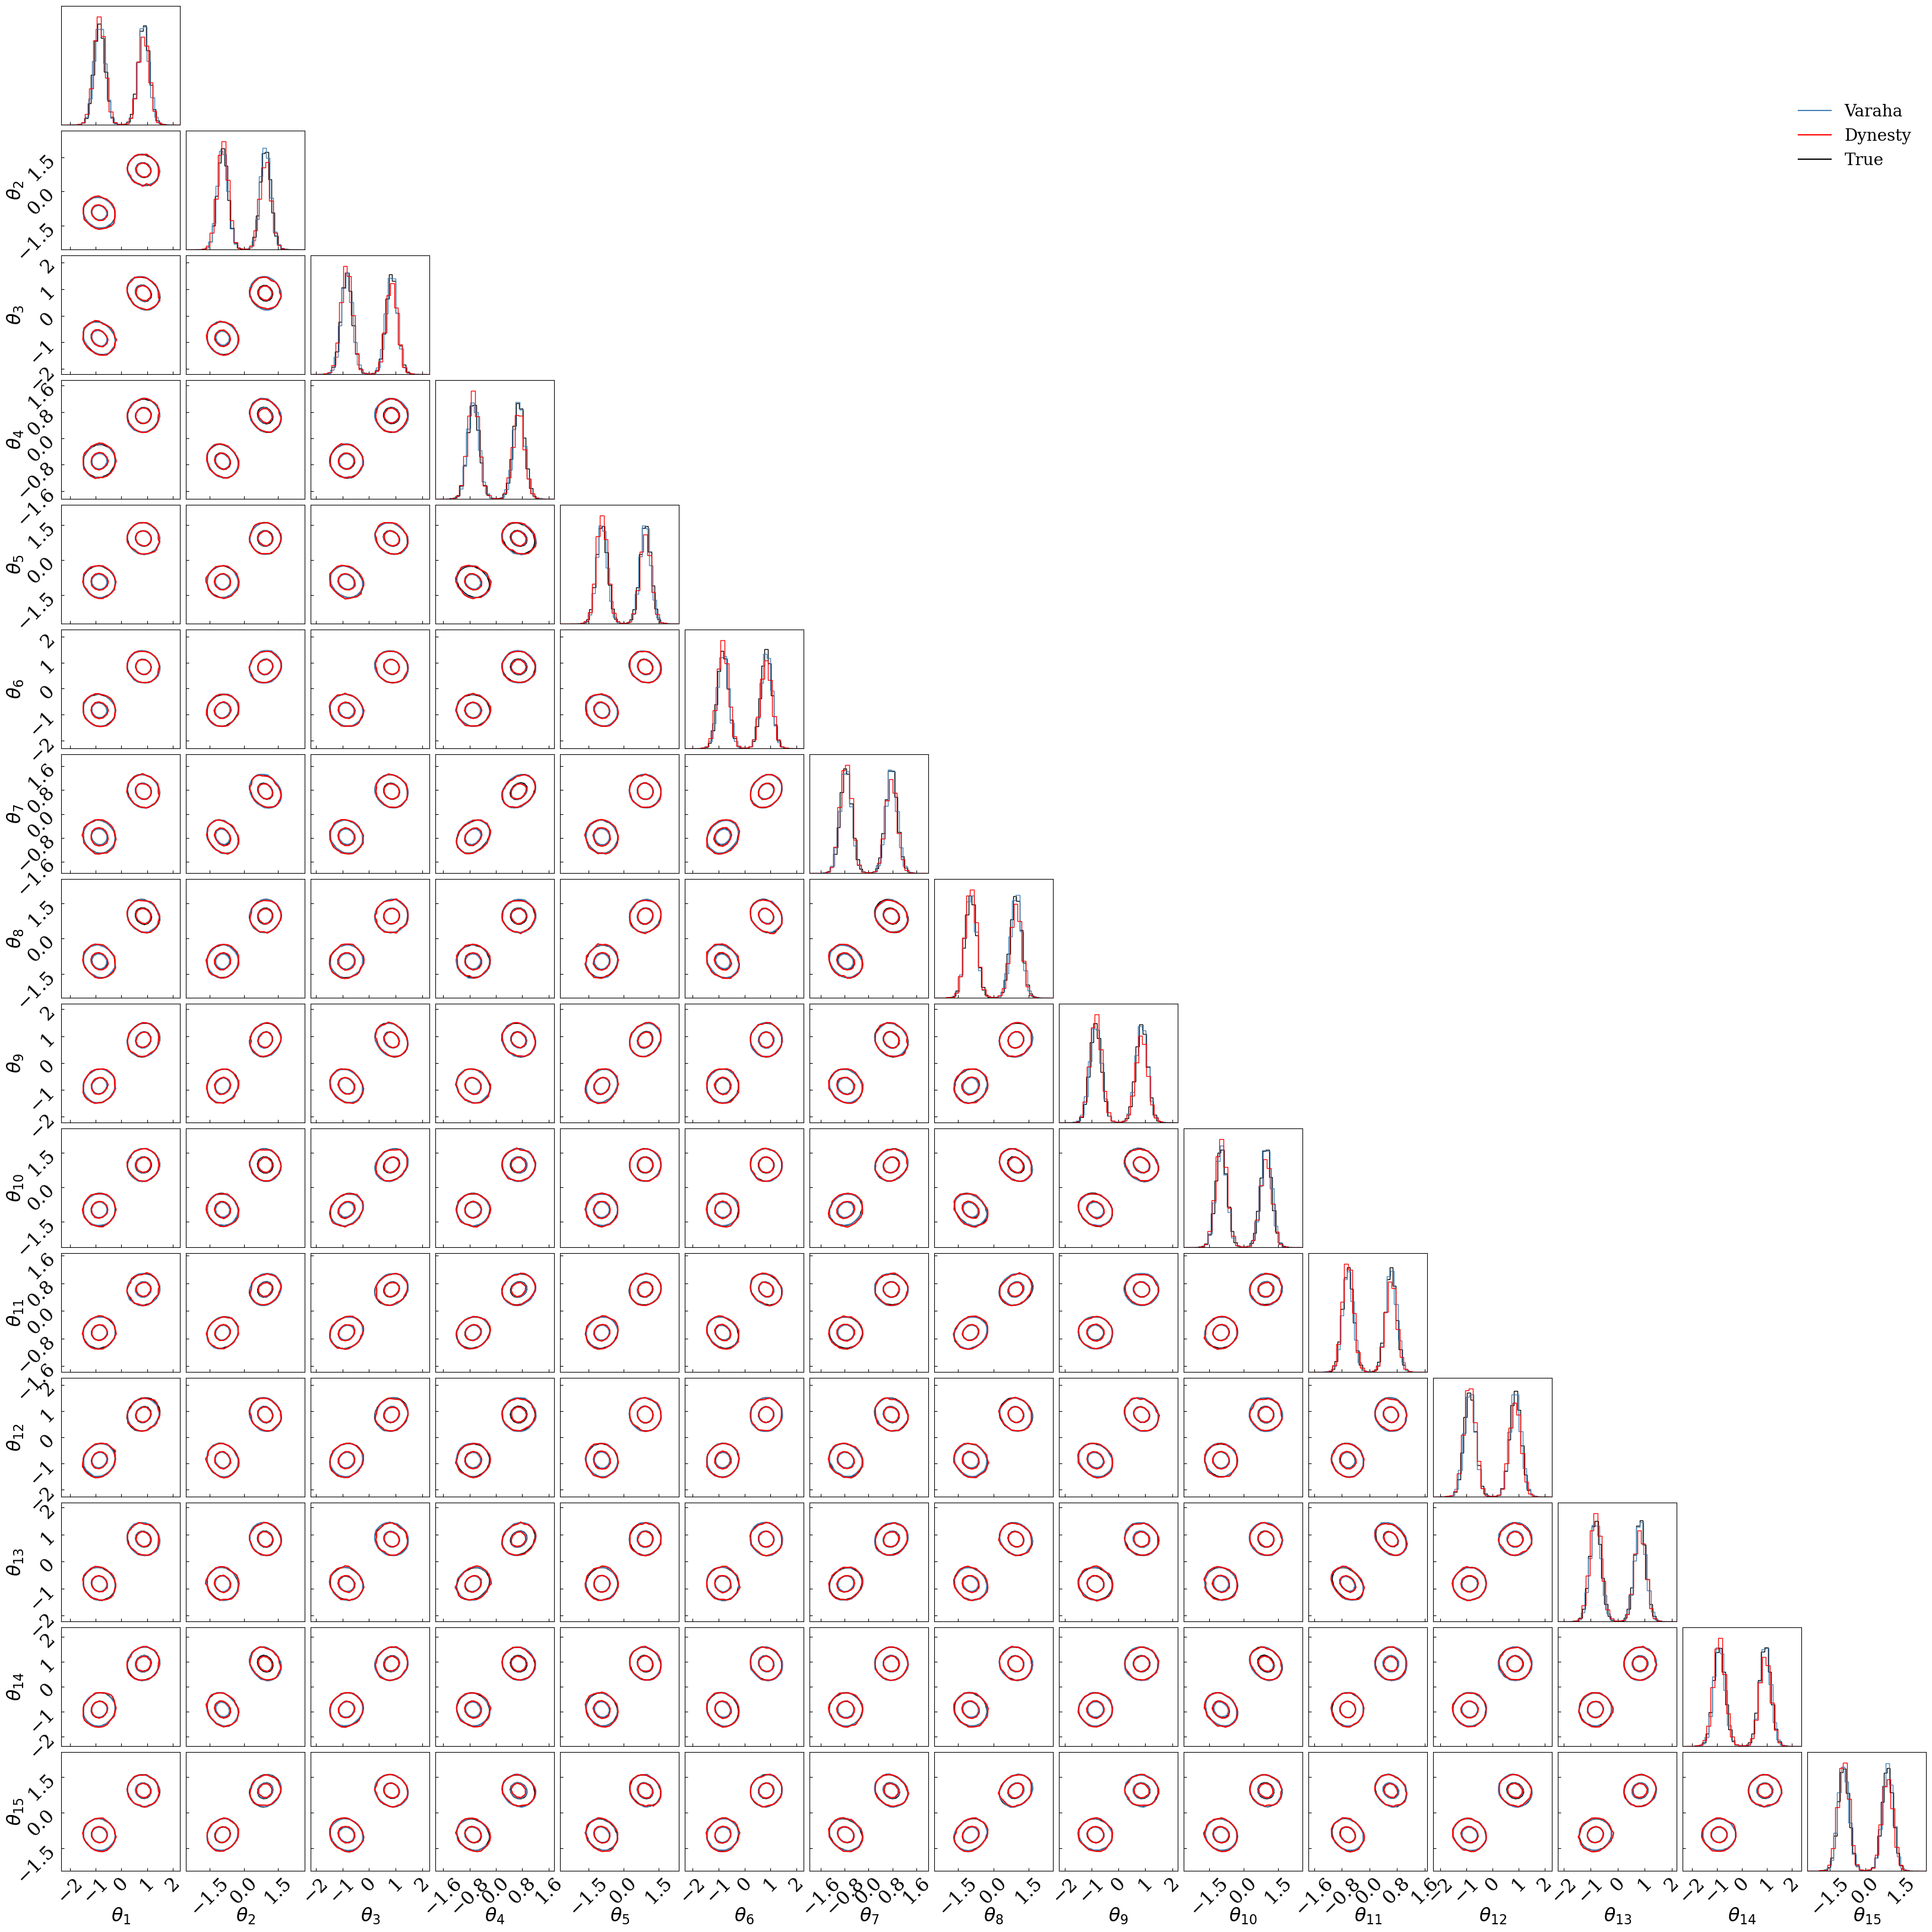

In [11]:
idx = np.where(w > 0.0000001)

l=[]
for ii in range(ndim):
    l.append(r'$\theta_{' + str(ii+1) + '}$')
hh = dict(density=True, color = 'black')
figure = corner.corner(true, bins = 30, levels=(1 - np.exp(-1.), 1 - np.exp(-4)), plot_density=False, 
                       plot_datapoints=False, color = 'black',labels=l, hist_kwargs=hh, max_n_ticks=5)
hh = dict(density=True, color = 'steelblue')
corner.corner(allx[idx], fig=figure, color='steelblue', bins = 30, levels=(1 - np.exp(-1.), 1 - np.exp(-4)), 
              plot_density=False, plot_datapoints=False, weights=w[idx], hist_kwargs=hh, max_n_ticks=3)
hh = dict(density=True, color = 'red')
corner.corner(res.samples[ns_idx], weights=dweights[ns_idx], fig=figure, color='red', bins = 30, levels=(1 - np.exp(-1), 
            1 - np.exp(-4)), plot_density=False, plot_datapoints=False, hist_kwargs=hh, density=True)
plt.legend(handles=[mlines.Line2D([], [], color='steelblue', label='Varaha'), mlines.Line2D([], [], color='red', 
    label='Dynesty'), mlines.Line2D([], [], color='black', label='True')], fontsize=20, frameon=False, 
           bbox_to_anchor=(1, ndim), loc="upper right")
plt.savefig('files/bimodal_gaussian.jpg', dpi = 150., bbox_inches  = 'tight')